# Importing Libraries

In [1]:
# For Data Processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import plotly.express as px
from imblearn.over_sampling import SMOTE

# Import ML Model Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# For Model Evaluation
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc 
from matplotlib import pyplot

# Importing data

In [2]:
colectomy_cci_var = pd.read_csv('./colectomy_cci_var.csv', dtype = 'str')
#colectomy_cci_var = pd.read_csv('./chf_readmit_1114.csv', dtype = 'str')

# Formating datatype

In [3]:
# Set random seed
np.random.seed(42)

# Rename columns
colectomy_cci_var['ptsex'] = colectomy_cci_var['ptsex'].replace({'F': 'female', 'M': 'male'})
colectomy_cci_var['adtype'] = colectomy_cci_var['adtype'].replace({'1': 'emergency', '2': 'urgent', '3': 'elective'})
colectomy_cci_var['adsource'] = colectomy_cci_var['adsource'].replace({'1': 'non_healthcare_facility', '2': 'clinical_referral', '4': 'hospital_transfer', '5': 'snf_icf_transfer', '6': 'healthcare_facility_tranfer', '7': 'emergency_room', '8': 'court_law_enforcement', 'D': 'hospital_unit_transfer', 'E': 'ambulatory_surgery_center'})

colectomy_cci_var['age'] = colectomy_cci_var['age'].astype(int)

colectomy_cci_var['paytype1'] = colectomy_cci_var['paytype1'].fillna('99')

# Drop observations
colectomy_cci_var = colectomy_cci_var[colectomy_cci_var['adsource'] != '9']
colectomy_cci_var = colectomy_cci_var[colectomy_cci_var['adsource'] != 'emergency_room']
#print(len(colectomy_cci_var))
colectomy_cci_var = colectomy_cci_var.groupby('pdx').filter(lambda x: len(x) >= 250)
#print(len(colectomy_cci_var))

# Select Relevant Features
features = ['year', 'ptsex', 'race', 'age', 'adtype', 'adsource', 'admdx']
dummy_features = ['year','ptsex', 'race', 'adtype', 'adsource']

# Data Preprocessing
num_secondary_admissions = 10

for i in range(1, num_secondary_admissions + 1):
    sdx = f'sdx{i}'

    features.append(sdx)

    # Replace missing values with the "unknown" category
    colectomy_cci_var[sdx] = colectomy_cci_var[sdx].fillna('unknown')

    # Target encoding
    category_counts = colectomy_cci_var[sdx].value_counts()
    colectomy_cci_var[sdx] = colectomy_cci_var[sdx].map(category_counts)

# Target encoding
category_counts = colectomy_cci_var['admdx'].value_counts()
colectomy_cci_var['admdx'] = colectomy_cci_var['admdx'].map(category_counts)

#for feature in features:
#    print(colectomy_cci_var[feature].value_counts())


In [4]:
# Extracting categorical and numerical columns
cat_cols = [col for col in colectomy_cci_var[features].columns if colectomy_cci_var[col].dtype == 'object']
num_cols = [col for col in colectomy_cci_var[features].columns if colectomy_cci_var[col].dtype != 'object']


In [ ]:
# checking numerical features distribution
plt.figure(figsize = (20, 15))
plotnumber = 1
for column in num_cols:
    if plotnumber <= 14:
        ax = plt.subplot(3, 4, plotnumber)
        sns.histplot (colectomy_cci_var[column], color = 'blue', kde = True, stat = "density", linewidth = 0)
        plt.xlabel(column)
    
        
    plotnumber += 1

plt.tight_layout()
plt.show()

/var/folders/cm/xf8t3rxj687fb5y5xqpyndrr0000gn/T/ipykernel_37170/1215541339.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = colectomy_cci_var[column], palette = 'deep', color = 'black', legend = False)
/var/folders/cm/xf8t3rxj687fb5y5xqpyndrr0000gn/T/ipykernel_37170/1215541339.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = colectomy_cci_var[column], palette = 'deep', color = 'black', legend = False)
/var/folders/cm/xf8t3rxj687fb5y5xqpyndrr0000gn/T/ipykernel_37170/1215541339.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.cou

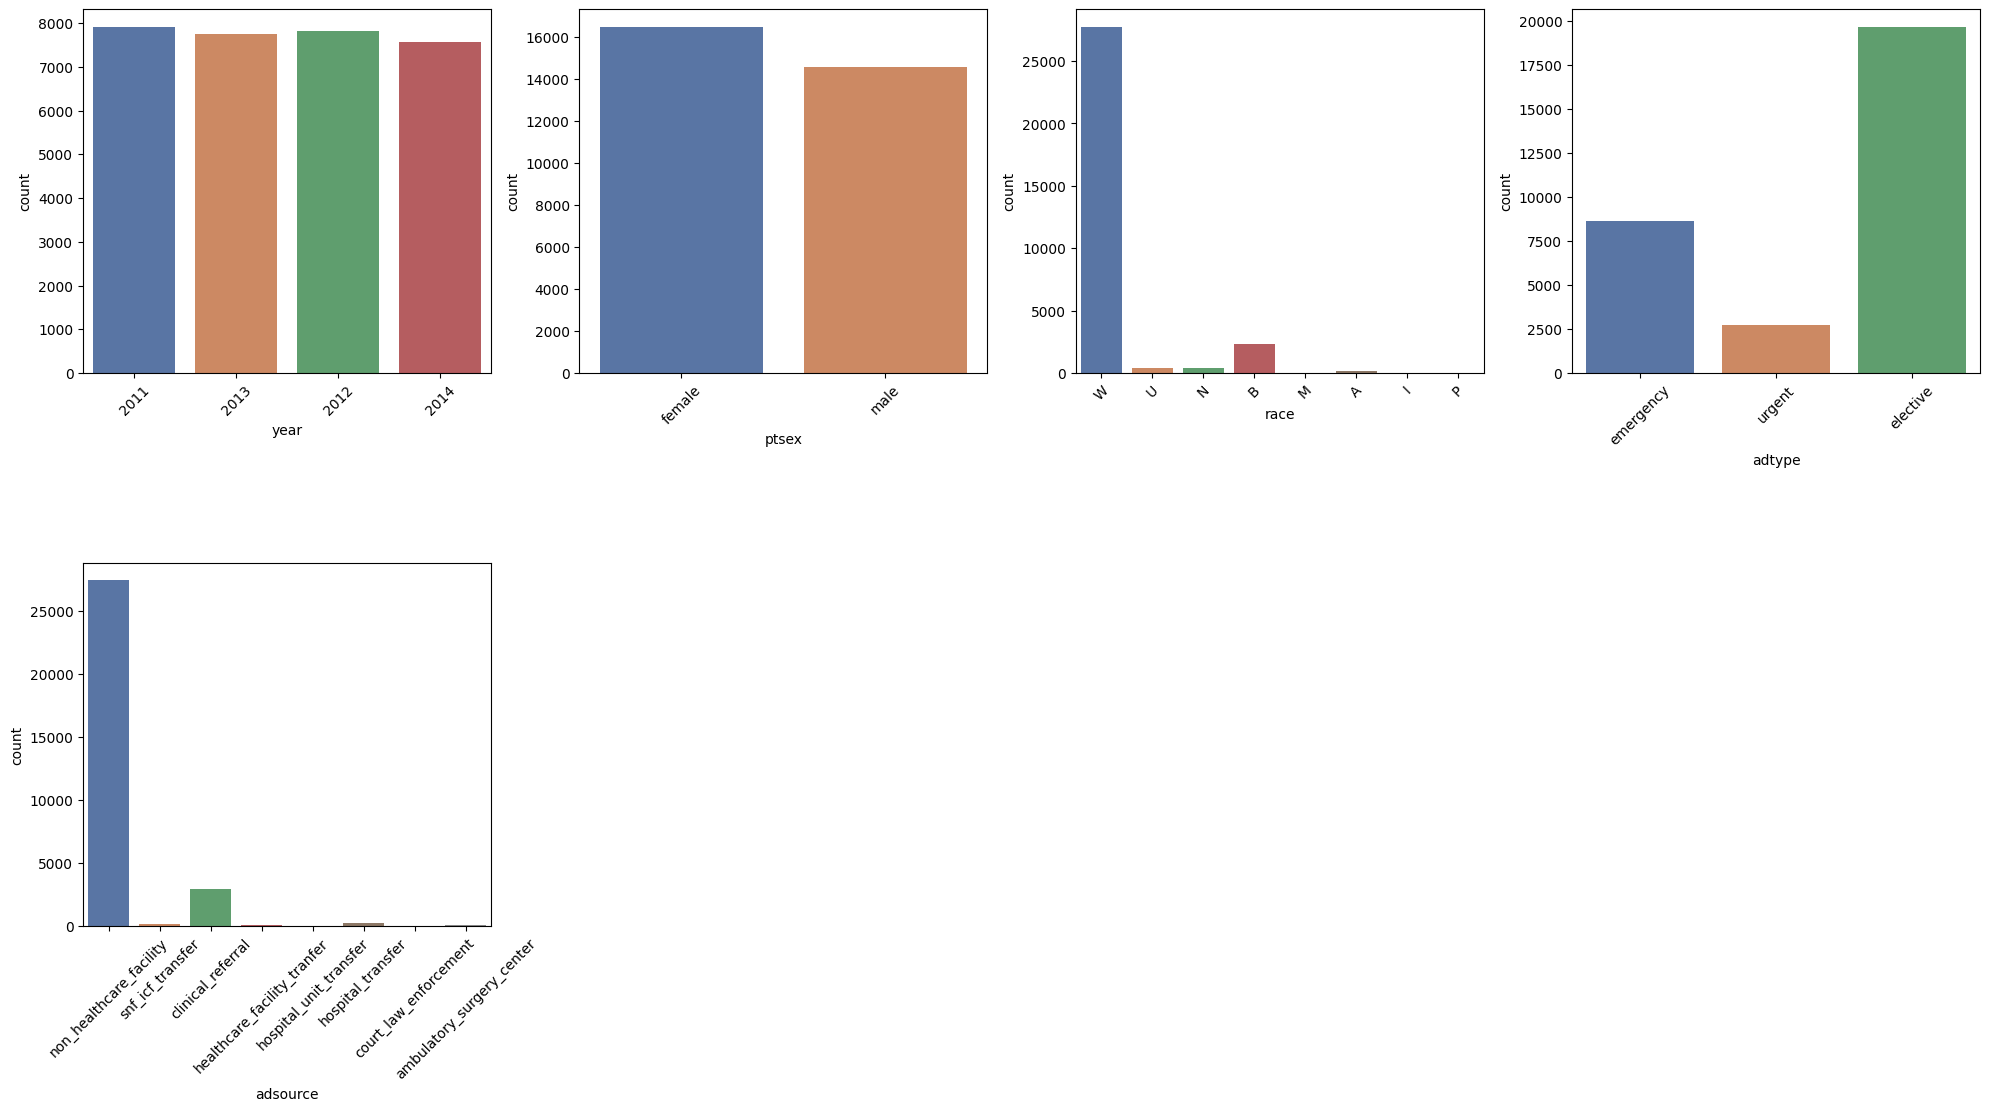

In [ ]:
# looking at categorical columns

plt.figure(figsize = (20, 15))
plotnumber = 1
for column in cat_cols:
    if plotnumber <= 11:
        ax = plt.subplot(3, 4, plotnumber)
        sns.countplot(x = colectomy_cci_var[column], palette = 'deep', color = 'black', legend = False)
        plt.xlabel(column)
        plt.xticks(rotation = 45)
        
    plotnumber += 1

plt.tight_layout()
plt.show()

In [ ]:
colectomy_cci_var_X = colectomy_cci_var[features]
colectomy_cci_var_y = colectomy_cci_var['pdx']

# One-Hot Encoding
colectomy_cci_var_X = pd.get_dummies(colectomy_cci_var_X, columns = dummy_features)

# Split Data
train_X, test_X, train_y, test_y = train_test_split(colectomy_cci_var_X, colectomy_cci_var_y, test_size = 0.2, random_state = 0)

# Data Resampling
#smote = SMOTE(sampling_strategy = 'auto', random_state = 0)
#train_X, train_y = smote.fit_resample(train_X, train_y)

# Label Encoding
encoder = LabelEncoder()
label_encoder = encoder.fit(train_y)
train_y = label_encoder.transform(train_y)
test_y = label_encoder.transform(test_y)

# Normalize Data
normalize_features = list(set(features) - set(dummy_features))

scaler = MinMaxScaler()

train_X_normalized = train_X.copy()
test_X_normalzied = test_X.copy()

normalizer = scaler.fit(train_X_normalized[normalize_features])

train_X_normalized[normalize_features] = normalizer.transform(train_X_normalized[normalize_features])
test_X_normalzied[normalize_features] = normalizer.transform(test_X_normalzied[normalize_features])

In [ ]:
# Split the training set into Medicare, Medicaid, Government Health Insurance
colectomy_cci_var_public = colectomy_cci_var[colectomy_cci_var['paytype1'].str.startswith(('1', '2', '8'))]
# Split the test set into Uninsured, Blue Cross, Commercial, leave out the Unknown insurance group
colectomy_cci_var_private_other = colectomy_cci_var[colectomy_cci_var['paytype1'].str.startswith(('0', '3', '4'))]

print(f"Length of training set: {len(colectomy_cci_var_public)}")
print(f"Length of testing set: {len(colectomy_cci_var_private_other)}")

train_X_OOD = colectomy_cci_var_public[features]
train_y_OOD = colectomy_cci_var_public['pdx'] 
test_X_OOD = colectomy_cci_var_private_other[features]
test_y_OOD = colectomy_cci_var_private_other['pdx']

# One-Hot Encoding
train_X_OOD = pd.get_dummies(train_X_OOD, columns = dummy_features)
test_X_OOD = pd.get_dummies(test_X_OOD, columns = dummy_features)

# Data Resampling
# Change variable names to OOD if this gets used
#smote = SMOTE(sampling_strategy = 'auto', random_state = 0)
#train_X, train_y = smote.fit_resample(train_X, train_y)

# Label Encoding
encoder = LabelEncoder()
label_encoder = encoder.fit(train_y_OOD)
train_y_OOD = label_encoder.transform(train_y_OOD)
test_y_OOD = label_encoder.transform(test_y_OOD)

# Normalize Data
normalize_features = list(set(features) - set(dummy_features))

scaler = MinMaxScaler()

train_X_OOD_normalized = train_X_OOD.copy()
test_X_OOD_normalzied = test_X_OOD.copy()

normalizer = scaler.fit(train_X_OOD_normalized[normalize_features])

train_X_OOD_normalized[normalize_features] = normalizer.transform(train_X_OOD_normalized[normalize_features])
test_X_OOD_normalzied[normalize_features] = normalizer.transform(test_X_OOD_normalzied[normalize_features])

Length of training set: 17640
Length of testing set: 13286


In [ ]:
X_train = train_X_normalized
X_test = test_X_normalzied
Y_train = train_y
Y_test = test_y

In [ ]:
X_train_OOD = train_X_OOD_normalized
X_test_OOD = test_X_OOD_normalzied
Y_train_OOD = train_y_OOD
Y_test_OOD = test_y_OOD

# Training Models

In [ ]:
# Random Forest
clf_rand_forest = RandomForestClassifier()
clf_rand_forest.fit(X_train, Y_train)

RandomForestClassifier()

In [ ]:
# SVM
clf_svm = svm.SVC(kernel = 'linear')
clf_svm.fit(X_train, Y_train)

SVC(kernel='linear')

In [ ]:
# Naive Bayes
clf_gnb = GaussianNB()
clf_gnb.fit(X_train, Y_train)

GaussianNB()

In [ ]:
# Logistic Regression
clf_log = LogisticRegression(solver = 'lbfgs', max_iter = 2500)
clf_log.fit(X_train, Y_train)

LogisticRegression(max_iter=2500)

In [ ]:
# KNN
clf_knn = KNeighborsClassifier(n_neighbors = 5)
clf_knn.fit(X_train, Y_train)

KNeighborsClassifier()

In [ ]:
# XG Boost
clf_xgb = XGBClassifier(objective = 'multi:softmax', 
                        learning_rate = 0.5, 
                        max_depth = 5, 
                        n_estimators = 150, 
                        eval_metric = 'mlogloss',  
                        use_label_encoder = False)
clf_xgb.fit(X_train, Y_train)

/opt/anaconda3/envs/DS340W/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:18:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.5, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, objective='multi:softmax', ...)

In [ ]:
# Decision Tree
clf_dtc = DecisionTreeClassifier()
clf_dtc.fit(X_train, Y_train)

DecisionTreeClassifier()

In [ ]:
# Ada Boost
clf_ada = AdaBoostClassifier(estimator = clf_dtc)
clf_ada.fit(X_train, Y_train)

/opt/anaconda3/envs/DS340W/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier())

# Training OOD Models

In [ ]:
# Random Forest
clf_rand_forest_OOD = RandomForestClassifier()
clf_rand_forest_OOD.fit(X_train_OOD, Y_train_OOD)

In [ ]:
# SVM
clf_svm_OOD = svm.SVC(kernel = 'linear')
clf_svm_OOD.fit(X_train_OOD, Y_train_OOD)

In [ ]:
# Naive Bayes
clf_gnb_OOD = GaussianNB()
clf_gnb_OOD.fit(X_train_OOD, Y_train_OOD)

In [ ]:
# Logistic Regression
clf_log_OOD = LogisticRegression(solver = 'lbfgs', max_iter = 2500)
clf_log_OOD.fit(X_train_OOD, Y_train_OOD)

In [ ]:
# KNN
clf_knn_OOD = KNeighborsClassifier(n_neighbors = 5)
clf_knn_OOD.fit(X_train_OOD, Y_train_OOD)

In [ ]:
# XG Boost
clf_xgb_OOD = XGBClassifier(objective = 'multi:softmax', 
                        learning_rate = 0.5, 
                        max_depth = 5, 
                        n_estimators = 150, 
                        eval_metric = 'mlogloss',  
                        use_label_encoder = False)
clf_xgb_OOD.fit(X_train_OOD, Y_train_OOD)

In [ ]:
# Decision Tree
clf_dtc_OOD = DecisionTreeClassifier()
clf_dtc_OOD.fit(X_train_OOD, Y_train_OOD)

In [ ]:
# Ada Boost
clf_ada_OOD = AdaBoostClassifier(estimator = clf_dtc_OOD)
clf_ada_OOD.fit(X_train_OOD, Y_train_OOD)

# Evaluation

### Random Forest

#### Classification Report

In [ ]:
Y_pred = clf_rand_forest.predict(X_test)

rand_forest_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {rand_forest_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.5482780817508851
Mean Absolute Error: 3.7779208239459288
Mean Squared Error: 51.44480205986482
Classification Report: 
              precision    recall  f1-score   support

           0       0.22      0.50      0.31       134
           1       0.24      0.24      0.24       117
           2       0.44      0.34      0.39       245
           3       0.28      0.20      0.23       110
           4       0.51      0.46      0.48       464
           5       0.50      0.37      0.43       473
           6       0.15      0.17      0.16        47
           7       0.47      0.46      0.47       536
           8       0.14      0.15      0.15        65
           9       0.20      0.15      0.17       117
          10       0.25      0.17      0.20        77
          11       0.42      0.45      0.44        66
          12       0.80      0.78      0.79       786
          13       0.17      0.25      0.20        57
          14       0.17      0.27      0.21        74
    

### SVM

#### Classification Report

In [ ]:
Y_pred = clf_svm.predict(X_test)

svm_acc = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {svm_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.4219504345027358
Mean Absolute Error: 5.510460251046025
Mean Squared Error: 81.62278725458641
Classification Report: 
              precision    recall  f1-score   support

           0       0.15      0.43      0.22       134
           1       0.08      0.04      0.05       117
           2       0.14      0.06      0.08       245
           3       0.09      0.01      0.02       110
           4       0.33      0.28      0.30       464
           5       0.14      0.10      0.12       473
           6       0.03      0.02      0.03        47
           7       0.33      0.32      0.32       536
           8       0.00      0.00      0.00        65
           9       0.12      0.03      0.04       117
          10       0.03      0.01      0.02        77
          11       0.09      0.26      0.13        66
          12       0.80      0.72      0.76       786
          13       0.09      0.16      0.11        57
          14       0.14      0.18      0.16        74
     

### Naive Bayes

#### Classification Report

In [ ]:
Y_pred = clf_gnb.predict(X_test)

gnb_acc = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {gnb_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.04505954296749276
Mean Absolute Error: 7.11763759253299
Mean Squared Error: 82.20099774702285
Classification Report: 
              precision    recall  f1-score   support

           0       0.24      0.04      0.08       134
           1       0.03      0.07      0.04       117
           2       1.00      0.00      0.00       245
           3       0.04      0.02      0.03       110
           4       0.25      0.02      0.04       464
           5       1.00      0.00      0.00       473
           6       0.03      0.06      0.04        47
           7       1.00      0.00      0.00       536
           8       1.00      0.00      0.00        65
           9       0.00      0.00      0.00       117
          10       0.00      0.00      0.00        77
          11       0.02      0.67      0.04        66
          12       0.15      0.00      0.01       786
          13       1.00      0.00      0.00        57
          14       0.13      0.16      0.15        74
     

### Logistic Regression

#### Classification Report

In [ ]:
Y_pred = clf_log.predict(X_test)

log_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {log_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.3619246861924686
Mean Absolute Error: 5.936755712906341
Mean Squared Error: 81.2891857096878
Classification Report: 
              precision    recall  f1-score   support

           0       0.16      0.33      0.22       134
           1       0.00      0.00      0.00       117
           2       0.33      0.01      0.02       245
           3       0.00      0.00      0.00       110
           4       0.23      0.13      0.16       464
           5       0.19      0.10      0.13       473
           6       0.08      0.04      0.06        47
           7       0.23      0.26      0.25       536
           8       0.00      0.00      0.00        65
           9       0.00      0.00      0.00       117
          10       0.00      0.00      0.00        77
          11       0.06      0.23      0.09        66
          12       0.43      0.45      0.44       786
          13       0.07      0.14      0.09        57
          14       0.13      0.23      0.17        74
      

### KNN

#### Classification Report

In [ ]:
Y_pred = clf_knn.predict(X_test)

knn_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {knn_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.3342452526552945
Mean Absolute Error: 6.2343096234309625
Mean Squared Error: 91.12069520437721
Classification Report: 
              precision    recall  f1-score   support

           0       0.10      0.26      0.15       134
           1       0.07      0.12      0.08       117
           2       0.07      0.10      0.08       245
           3       0.04      0.06      0.05       110
           4       0.18      0.21      0.19       464
           5       0.14      0.13      0.13       473
           6       0.02      0.02      0.02        47
           7       0.20      0.18      0.19       536
           8       0.03      0.03      0.03        65
           9       0.03      0.03      0.03       117
          10       0.02      0.01      0.02        77
          11       0.05      0.05      0.05        66
          12       0.63      0.55      0.59       786
          13       0.17      0.16      0.16        57
          14       0.09      0.11      0.10        74
    

### XG_Boost

#### Classification Report

In [ ]:
Y_pred = clf_xgb.predict(X_test)

xgb_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {xgb_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.6358223366591568
Mean Absolute Error: 2.565497264242034
Mean Squared Error: 30.75989700675893
Classification Report: 
              precision    recall  f1-score   support

           0       0.49      0.56      0.52       134
           1       0.54      0.36      0.43       117
           2       0.55      0.49      0.52       245
           3       0.40      0.26      0.32       110
           4       0.63      0.59      0.61       464
           5       0.50      0.48      0.49       473
           6       0.50      0.47      0.48        47
           7       0.50      0.58      0.53       536
           8       0.38      0.34      0.36        65
           9       0.21      0.20      0.20       117
          10       0.53      0.39      0.45        77
          11       0.58      0.39      0.47        66
          12       0.76      0.83      0.80       786
          13       0.30      0.30      0.30        57
          14       0.22      0.26      0.24        74
     

### Decision Tree

#### Classification Report

In [ ]:
Y_pred = clf_dtc.predict(X_test)

dtc_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {dtc_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.5312198261989057
Mean Absolute Error: 3.7257804956549725
Mean Squared Error: 48.66108786610879
Classification Report: 
              precision    recall  f1-score   support

           0       0.22      0.29      0.25       134
           1       0.25      0.29      0.27       117
           2       0.38      0.40      0.39       245
           3       0.20      0.22      0.21       110
           4       0.56      0.48      0.52       464
           5       0.48      0.41      0.44       473
           6       0.27      0.43      0.33        47
           7       0.54      0.49      0.51       536
           8       0.17      0.26      0.20        65
           9       0.11      0.14      0.12       117
          10       0.23      0.34      0.27        77
          11       0.38      0.38      0.38        66
          12       0.77      0.69      0.73       786
          13       0.04      0.07      0.05        57
          14       0.08      0.11      0.09        74
    

### Ada Boost

#### Classification Report

In [ ]:
Y_pred = clf_ada.predict(X_test)

ada_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {ada_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.5431284196974574
Mean Absolute Error: 3.666237528162214
Mean Squared Error: 48.34663662697135
Classification Report: 
              precision    recall  f1-score   support

           0       0.16      0.21      0.18       134
           1       0.34      0.39      0.37       117
           2       0.42      0.44      0.43       245
           3       0.25      0.33      0.28       110
           4       0.57      0.52      0.54       464
           5       0.49      0.40      0.44       473
           6       0.23      0.32      0.27        47
           7       0.56      0.48      0.52       536
           8       0.19      0.26      0.22        65
           9       0.12      0.13      0.12       117
          10       0.31      0.43      0.36        77
          11       0.38      0.39      0.39        66
          12       0.78      0.72      0.75       786
          13       0.10      0.14      0.12        57
          14       0.17      0.24      0.20        74
     

# Model Comparison

In [ ]:
models = pd.DataFrame({
    'Model' : [ 'Random Forest Classifier', 'SVM Classifier', 'Naive Bayes Classifier','KNN Classifier', 'XG_Boost Classifier', 'Decision Tree Classifier', 'Ada_Boost Classifier'],
    'Score' : [rand_forest_acc, svm_acc, gnb_acc, knn_acc, xgb_acc, dtc_acc, ada_acc]
})

sorted_models = models.sort_values(by = 'Score', ascending = True)

fig = px.bar(data_frame = sorted_models, x = 'Score', y = 'Model', title = 'Models Comparison')

fig.show()

In [ ]:
Y_pred = clf_rand_forest_OOD.predict(X_test_OOD)

rand_forest_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {rand_forest_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

In [ ]:
Y_pred = clf_svm_OOD.predict(X_test_OOD)

svm_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {svm_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

In [ ]:
Y_pred = clf_gnb_OOD.predict(X_test_OOD)

gnb_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {gnb_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

In [ ]:
Y_pred = clf_log_OOD.predict(X_test_OOD)

log_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {log_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

In [ ]:
Y_pred = clf_knn_OOD.predict(X_test_OOD)

knn_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {knn_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

In [ ]:
Y_pred = clf_xgb_OOD.predict(X_test_OOD)

xgb_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {xgb_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

In [ ]:
Y_pred = clf_dtc_OOD.predict(X_test_OOD)

dtc_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {dtc_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

In [ ]:
Y_pred = clf_ada_OOD.predict(X_test_OOD)

ada_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {ada_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

In [ ]:
models = pd.DataFrame({
    'Model' : [ 'Random Forest Classifier', 'SVM Classifier', 'Naive Bayes Classifier','KNN Classifier', 'XG_Boost Classifier', 'Decision Tree Classifier', 'Ada_Boost Classifier'],
    'Score' : [rand_forest_acc_OOD, svm_acc_OOD, gnb_acc_OOD, knn_acc_OOD, xgb_acc_OOD, dtc_acc_OOD, ada_acc_OOD]
})

sorted_models = models.sort_values(by = 'Score', ascending = True)

fig = px.bar(data_frame = sorted_models, x = 'Score', y = 'Model', title=  'Models Comparison')

fig.show()